In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("projA2.ipynb")

# Project A.2: Predicting Housing Prices in Cook County

## Due Date: Thursday, March 23rd, 11:59 PM

You must submit this assignment to Gradescope by the on-time deadline, Thursday, March 23rd, 11:59 PM. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to last-minute requests for assistance (TAs need to sleep, after all!). **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for submission support. 

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the project, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the collaborators cell below.

**Collaborators:** *list names here*

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 00: Mid-semester survey

Please fill out the mid-semester survey [here](https://forms.gle/NioqqTuxHGHi25dPA). We appreciate your feedback! Note: The public test only checks if you enter the password in the correct format.

In [2]:
qsurvey = "ogGM_pzr3ybW"

In [3]:
grader.check("qsurvey")

qsurvey results: All test cases passed!



<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />
<br/><br/>

## Introduction

In project A.1, you performed some basic Exploratory Data Analysis (EDA), laying out the thought process that leads to certain modeling decisions. Then, you added a few new features to the dataset and cleaned the data in the process.

In this project, you will specify and fit a linear model to a few features of the housing data to predict house prices. Next, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this project - and think about what fairness might mean to property owners in Cook County.

After this part of the project, you should be comfortable with:
- Implementing a data processing pipeline using `pandas`.
- Using `scikit-learn` to build and fit linear models.

## Score Breakdown

Question | Manual | Points
----|----|----
00 | No| 2
0a | Yes | 1
0b | Yes | 1
0c | No | 1
0d | Yes | 1
0e | Yes | 1
1 | No | 2
2a | Yes | 2
2b | No | 3
2c | No | 2
3a | No | 2
3b | Yes | 2
3c | Yes | 2
3d |  No | 1
4a | No | 0
4b | No | 0
4c | No | 0
4d | No | 0
4e | No | 3
Test Prediction | No | 3
4f | No | 0
4g | No | 0
4h | No | 0
5 | Yes | 2
6a | Yes | 2
6b | Yes | 1
6c | Yes | 1
Total | 11 | 35


In [4]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training/validation and test data.

In [5]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

The dataset was split into a testing and training set, train on the training set, and compare the prediction on the test set to the observed values. We saved the test set as `cook_county_contest_test.csv` for you, and the rest of the data is saved as `cook_county_train_val.csv`. Note that we have also removed the prediction `Sale Price` column from this test set, so you will not be able to use it for training. Only autograder on Gradescope has acces to these true values.

In [6]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [7]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Let's remind ourselves of the data available to us in the Cook County dataset. Remember, a more detailed description of each variable is included in `codebook.txt`, which is in the same directory as this notebook). **If you did not attempt Project A1,** you should take some time to familiarize yourself with the codebook before moving forward.

In [8]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<!-- BEGIN QUESTION -->

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 0: Human Context and Ethics

<br><br>

--- 

### Question 0a
"How much is a house worth?" Who might be interested in an answer to this question? **Please list at least three different parties (people or organizations) and state whether each one has an interest in seeing the housing price to be high or low.**


The three different parties that would be interested in having an answer to this question would be the property owners themselves, potential buyers for a home, and the local tax collectors. Depending on if the owner is selling or keeping their home, they would want their house value to be high when trying to get it onto the market to get the most profit, and they would want it low when choosing to stay on their property since they would be less on taxes. Those interested in buying would prefer housing prices that are low since they are the ones who are paying for it. And finally, tax collectors would be interested in seeing the housing price to be high as that means they will be getting more money from the property owners. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

--- 

### Question 0b

Which of the following scenarios strike you as unfair and why? You can choose more than one. There is no single right answer, but you must explain your reasoning.

A. A homeowner whose home is assessed at a higher price than it would sell for.  
B. A homeowner whose home is assessed at a lower price than it would sell for.  
C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.



I would say that all of these scenarios are unfair. Going down the list, although scenario A would benefit the homeowner, it is ultimately unfair for the potential buyers because they are paying for overvalued property and are not going to be getting what they will pay for. Scenario B is unfair for the homeowners since they would be losing money in trying to sell property that has been underappreciated. Scenario C is a system in which the people benefiting are already in fortunate positions, while treating those who are struggling financially unfairly. Scenario D, although not as bad as scenario C, the principle of having properties that are not valued correctly is unfair to any prospective buyers for that property. Even though having undervalued inexpensive property would allow for more room for buyer accessibility, the person trying to sell that property is being ripped off.  

<!-- END QUESTION -->

<br><br>

--- 

### Question 0c

Consider a model that is fit to $n = 30$ training observations. Call the response $y$ (Log Sale Price), the predictions $\hat{y}$, and the residuals $y - \hat{y}$. Which of the following residual plots of $y$ versus $y - \hat{y}$ correspond to a model that might make property assessments that result in to regressive taxation? Regressive taxation overvalues inexpensive properties and undervalues expensive propertie.

![](res-plots.png)


In [9]:
q0c = "A"

In [10]:
grader.check("q0c")

q0c results: All test cases passed!

## The CCAO Dataset

The dataset you’ll be working with comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing “[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

And make sure to watch Lecture 18 before answering the following questions!

<!-- BEGIN QUESTION -->

<br><br>

--- 

### Question 0d

What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune ? And what were the primary causes of these problems? (Note: in addition to reading the paragraph above you will need to watch the lecture to answer this question)

The central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune are that they placed a heavy tax burden on those who not only raked in less income but also on those who were non-white. According to the Tribune analysis, as one's household income increased, the percentage of that household's tax rates decreased, showing a reggressive taxation pattern that benefits the wealthy. On top of that, a lawsuit against the previous County Assessor revealed that there was a negative association between what perentage of white you were and the percentage of how over/under the assessment was to the true value of the property. The primary cause of these issues was the result of trying to professionalize the property assessment system. When deciding factors that affected the appraisal values of these properties, race became one of the big influences. Because of this, it reinforced federal policies to also be biased against non-whites and systems like redlining became put into place. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

--- 

### Question 0e

In addition to being regressive, how did the property tax system in Cook County place a disproportionate tax burden on non-white property owners?

The property tax system in Cook County placed a disproportionate tax burden on non-white property owners even further because it perpetuated a guise of an equitable system by allowing for people to appeal to change the percentage of how much they were taxed. The issue with this is that only those with wealthier statuses have the time and resources to appeal, which only works to widen the disparity between the two financial groups. 

<!-- END QUESTION -->

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 1: Preparing Data


Let's split the dataset into a training set and validation set. We will use the training set to fit our model's parameters, and we will use the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

In the cell below, complete the function `train_val_split` that splits `data` into two smaller DataFrames named `train` and `validation`. Let `train` contain 80% of the data, and let `validation` contain the remaining 20% of the data. You should not be importing any additional libraries for this question. Your answer should use the variabale `shuffled_indices` defined for you. Take a look at the`np.permuation` [documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html).

**Note**: 

You may see that some sources uses the name holdout, validation, or test synonymously since all of them are not used for training directly. There is no difference between holdout and validation set, both can be used for hyperparameter tuning. However, test set should only be used for final unbiased evaluation.

**Hint:**

While there are multiple solutions, one way is to create two `NumPy` arrays named `train_indices` and `validation_indices` (or any varaible names of your choice) that contain a *random* 80% of the indices in `full_data`, and the remaining 20% of the indices, respectively. Then, use these arrays to index into `full_data` to create your final `train` and `validation` DataFrames. To ensure that your code matches to our solution, use the first 80% as the the training set and the last 20% as the validation set. 

*The provided tests check that you not only answered correctly, but ended up with the exact same train/validation split as our reference implementation. Later testing is easier this way.*

In [11]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_val_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    split = int(data_len * .80)
    train_indices = shuffled_indices[0:split]
    valid_indices = shuffled_indices[split:data_len]
    train = data.iloc[train_indices]
    validation = data.iloc[valid_indices]
   
    return train, validation
train, validation = train_val_split(training_val_data)

In [12]:
grader.check("q1")

q1 results: All test cases passed!

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 2: Fitting a Simple Model

Now, let's fit our updated linear regression model using the ordinary least squares estimator! We will start you off with something simple by using only 2 features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our 1st linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a 2nd model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<!-- BEGIN QUESTION -->

<br><br>

--- 

## Question 2a

**Without running any calculation or code**, complete the following statement by filling in the blank with one of the  comparators below:

$$\ge$$
$$\le$$
$$=$$

Suppose we quantify the loss on our linear models using MSE (Mean Squared Error). Consider the training loss of the 1st model and the training loss of the 2nd model. We are guaranteed that:

$$
\text{Training Loss of the 1st Model}  \_\_\_\_\_  \text{Training Loss of the 2nd Model}
$$


≥

<!-- END QUESTION -->

<br><br>

### Pipeline function

In A.1, you wrote a few functions that added features to the dataset. Instead of calling them manually one-by-one each time, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  Below, we combined some functions into a single helper function that outputs X and y for the first model above. Try to undestand what this function does! 

**Note:** We have automatically imported staff implementations of the functions you wrote in Project A.1. These functions are `remove_outliers`, `add_total_bedrooms`, `find_expensive_neighborhoods`, `add_in_expensive_neighborhood`, and `ohe_roof_material`. You are welcome to copy over your own implementations if you like.

In [13]:
from feature_func import *    # Import functions from Project A1

###### Copy any function you would like to below ######
...
#######################################################


def process_data_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedrooms column
    data = add_total_bedrooms(data)
    # Select X and y from the full data
    X = data[['Bedrooms']]
    y = data['Log Sale Price']
    return X, y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, y_train_m1_simple = process_data_simple(train_m1)
X_valid_m1_simple, y_valid_m1_simple = process_data_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(y_train_m1_simple.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

### `.pipe`

Alternatively, we build the pipeline using `pd.DataFrame.pipe` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html)). Take a look at our use of `pd.DataFrame.pipe` below. 

The following function `process_data_gm` takes in a dataframe `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). You can use this function with each of the tuples passed in through `pipeline_functions`.

In [14]:
# Run this cell to define process_data_gm and select_columns, no futher actions needed.
def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    y = data.loc[:, prediction_col]
    return X, y

<br><br>

--- 

## Question 2b

It is time to prepare the training and validation data for the two models we proposed above. Use the following 2 cells to reload a fresh dataset from scratch and run them through the following preprocessing steps using `process_data_gm` for each model:

- Perform a `train_val_split` on the original dataset. Let 80% of the set be training data and 20% of the set be validation data. 
- For both the training and validation set,
    1. Remove outliers in `Sale Price` by so that we are considering households with a price that is strictly greater than 499 dollars (i.e., greater than or equal to 500 dollars). 
    2. Apply log transformations to `Sale Price` and the `Building Square Feet` columns to create 2 new columns `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bedrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` as well if this is the 2nd model). We have implemented the helper function `select_columns` for you.
    5. Return the design matrix $X$ and the observed vector $y$. **Your design matrix and observed vector should either be numpy arrays or pandas dataframes**.

Assign the final training data and validation data for both models to the following set of variables:

- 1st Model: `X_train_m1`, `y_train_m1`, `X_valid_m1`, `y_valid_m1`. This is already implemented for you. 
- 2nd Model: `X_train_m2`, `y_train_m2`, `X_valid_m2`, `y_valid_m2`. Please implement this in the second cell below. You may use the first model as an example.

Please save your pipelines functions as a list of tuples and assign it to `m1_pipelines` for model 1 and `m2_pipelines` for model 2 for the purpose of grading. See an example below.

**Note**: 
* Do not change the line `np.random.seed(1337)` as it ensures we are partitioning the dataset exactly the same way for both models (otherwise their performance isn't directly comparable).

In [15]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, y_train_m1 = process_data_gm(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, y_valid_m1 = process_data_gm(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by process_data_simple
display(X_train_m1.head())
display(y_train_m1.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [16]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
full_data = pd.read_csv("cook_county_train.csv")
train_m2, valid_m2 = train_val_split(full_data)

m2_pipelines = [(remove_outliers, None, {'variable' : 'Sale Price', 'lower' : 499}), 
               (log_transform, None, {'col': 'Sale Price'}),
               (log_transform, None, {'col': 'Building Square Feet'}), 
               (add_total_bedrooms, None, None),
               (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)]

X_train_m2, y_train_m2 = process_data_gm(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, y_valid_m2 = process_data_gm(valid_m2, m2_pipelines, 'Log Sale Price')


# Take a look at the result
display(X_train_m1_simple.head())
display(y_train_m1_simple.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [17]:
grader.check("q2b")

q2b results: All test cases passed!

<br><br>

--- 

## Question 2c

Finally, let's do some regression!

We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [18]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Now it's time to fit our linear regression model. Use the cell below to fit both models, and then use it to compute the fitted values of `Log Sale Price` over the training data, and the predicted values of `Log Sale Price` for the validation data.

Assign the predicted values from both of your models on the training and validation set to the following variables:

- 1st Model: **predicted values** on training set: `y_fitted_m1`, **predicted values** on validation set: `y_predicted_m1`
- 2nd Model: **predicted values** on training set: `y_fitted_m2`, **predicted values** on validation set: `y_predicted_m2`

**Note**: To make sure you understand how to find the predicted value for both the training and validation data set, there won't be any hidden tests for this part.

In [19]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, y_train_m1)
# Compute the fitted and predicted values of Log Sale Price for 1st model
y_fitted_m1 = linear_model_m1.predict(X_train_m1)
y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for 2nd model
y_fitted_m2 = linear_model_m2.predict(X_train_m2)
y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

In [20]:
grader.check("q2c")

q2c results: All test cases passed!

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 3: Evaluate Our Simple Model

<br><br>

--- 

## Question 3a


We are moving into analysis of our two models! Let's compare the performance of our two regression models using the Root Mean Squared Error (RMSE) function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in valid set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of of houses}}}$$

The function is provided below.

In [21]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

Now use your `rmse` function to calculate the training error and valid error for both models in the cell below. Since our model predicts `Log Sale Price`, we may compute RMSE between the predicted and observed `Log Sale Price`.

Assign the error from both of your models to the following variables:

- 1st model: `training_error_m1`, `valid_error_m1`
- 2nd model: `training_error_m2`, `valid_error_m2`

However, the target variable `Log Sale Price` we are working with is log-transformed and often difficult to interpret. It can also be beneficial to transform it back to its original form and then compute the RMSE so we will have more context on how our model is performing when compared to actual housing prices. Compute RMSE between the predicted and observed `Sale Price`.

Assign the error on the "de-log-transformed" sale price from both of your models to the following variables:

- 1st model: `training_error_m1_delog`, `valid_error_m1_delog`
- 2nd model: `training_error_m2_delog`, `valid_error_m2_delog`


In [22]:
# Training and validation errors for the 1st model
training_error_m1 = rmse(y_fitted_m1, y_train_m1)
validation_error_m1 = rmse(y_predicted_m1, y_valid_m1)

# Training and validation errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = rmse(np.exp(y_fitted_m1), np.exp(y_train_m1))
validation_error_m1_delog = rmse(np.exp(y_predicted_m1), np.exp(y_valid_m1))


# Training and validation errors for the 2nd model
training_error_m2 = rmse(y_fitted_m2, y_train_m2)
validation_error_m2 = rmse(y_predicted_m2, y_valid_m2)


# Training and validation errors for the 2nd model (in its original values before the log transform)
training_error_m2_delog = rmse(np.exp(y_fitted_m2), np.exp(y_train_m2))
validation_error_m2_delog = rmse(np.exp(y_predicted_m2), np.exp(y_valid_m2))

print("1st Model\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m1, validation_error_m1))
print("1st Model (no log transform)\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m1_delog, validation_error_m1_delog))
print("2nd Model\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m2, validation_error_m2))
print("2nd Model (no log transform)\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m2_delog, validation_error_m2_delog))

1st Model
Training RMSE: 0.9025651719699077
Validation RMSE: 0.9068644732045896

1st Model (no log transform)
Training RMSE: 382697.78149699024
Validation RMSE: 310679.2486611569

2nd Model
Training RMSE: 0.8042009333446841
Validation RMSE: 0.8113963052434995

2nd Model (no log transform)
Training RMSE: 325716.40819160367
Validation RMSE: 254880.42228506133



In [23]:
grader.check("q3a")

q3a results: All test cases passed!

<br><br>

Let's compare the actual parameters ($\theta_0$ and $\theta_1$) from both of our models. As a quick reminder,

for the 1st model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

for the 2nd model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

Run the following cell and compare the values of $\theta_1$ from both models. 

In [24]:
# Parameters from 1st model
theta0_m1 = linear_model_m1.intercept_
theta1_m1 = linear_model_m1.coef_[0]

# Parameters from 2nd model
theta0_m2 = linear_model_m2.intercept_
theta1_m2, theta2_m2 = linear_model_m2.coef_

print("1st Model\nθ_0: {}\nθ_1: {}".format(theta0_m1, theta1_m1))
print("2nd Model\nθ_0: {}\nθ_1: {}\nθ_2: {}".format(theta0_m2, theta1_m2, theta2_m2))

1st Model
θ_0: 10.571725401040084
θ_1: 0.4969197463141442
2nd Model
θ_0: 1.9339633173823696
θ_1: -0.030647249803554506
θ_2: 1.4170991378689644


<!-- BEGIN QUESTION -->

<br><br>

--- 

## Question 3b

You should oberseve that $\theta_1$ change from positive to negative when we introduce an additional feature in our 2nd model.  Provide a reasoning why this may occur. **Hint:** which feature is more useful is predicting `Log Sale Price`? 

The parameters of a linear regression model reveal the relationship between their respective features and whatever is being predicted. So, one reasoning as to why $\theta_1$ would change from positive to negative when we introduced an additional feature is because the weight of using the Bedrooms column as a feature is no longer as important. In this case, using the Log Building Square Feet column is much more beneficial to use in predicting the Log Sale Price than the number of Bedrooms of each home. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

--- 

## Question 3c

Another way of understanding the performance (and appropriateness) of a model is through a plot of the residuals versus the observations.

In the cell below, use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot the residuals from predicting `Log Sale Price` using **only the 2nd model** against the original `Log Sale Price` for the **validation data**. With a data size this large, it is diffult to avoid overplotting entirely. You should also ensure that the dot size and opacity in the scatter plot are set appropriately to reduce the impact of overplotting as much as possible.

Text(0, 0.5, 'Residual')

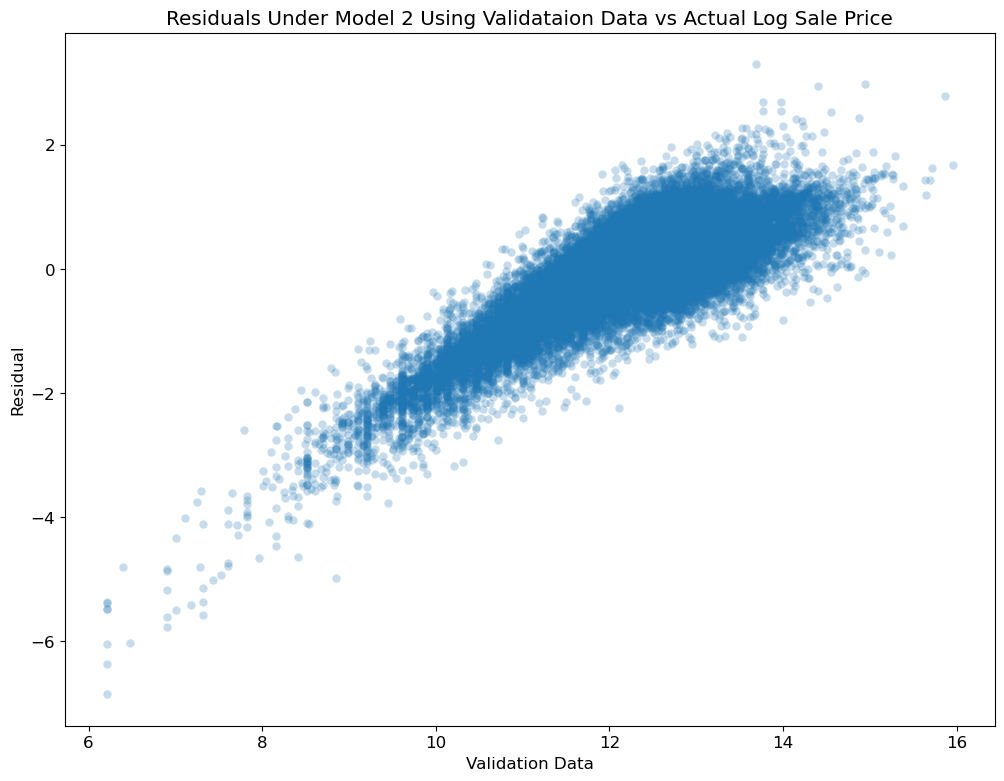

In [25]:
plt.scatter(y_valid_m2, y_valid_m2 - y_predicted_m2, alpha=0.25, linewidths=0.01)
plt.title("Residuals Under Model 2 Using Validataion Data vs Actual Log Sale Price")
plt.xlabel("Validation Data")
plt.ylabel("Residual")

<!-- END QUESTION -->

<br><br>

--- 

## Question 3d

Based on the structure you see in your plot, does this model seem like it will correspond to _regressive_, _fair_, or _progressive_ taxation?


In [26]:
q7b = "regressive"

In [27]:
grader.check("q3d")

q3d results: All test cases passed!

While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement to be made -- one reason is we have been only utilizing 1 or 2 features (out of a total of 70+) so far! Can you engineer and incoporate more features to improve the model's fairness and accuracy? We won't be asking you to provide your answers here, but this would be important going into the next part (also last part, wohoo!) of this project.

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 4

It is time to build your own model!

To evaluate your model, we will start by defining a linear regression model. Then, we will process training data using your `process_data_fm` function (you will define this in 4e), fit the model with this training data, and compute the training RMSE. Then, we will process test data with your `process_data_fm`, use the model to predict `Log Sale Price` for the test data, transform the predicted and original log values back into their original forms (by using `delog`), and compute the test RMSE.


### Grading Scheme

Your grade for Question 4 will be based on your training RMSE and contest **test** RMSE (note that this is another test set, separate from our existing test set!). The thresholds are as follows:

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Training RMSE | Less than 200k | [200k, 240k) | [240k, 280k) | More than 280k

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Test RMSE | Less than 240k | [240k, 280k) | [280k, 300k) | More than 300k


<br><br>

---
## Question 4a Couple notes

- **If you are running into memory issues, restart kernel and only run the cells you need to.** The cell below (question cell) contains most to all of the imports necessary to successfully complete this portion of the project, so it can be completed (almost) independently code-wise from the remainder of the project. The autograder will have more than 4 GB memory, so you will not lose credit as long as your solution to Question 4 is within the total memory (4GB) limits of DataHub. Alternatively, you can delete variables you are not using through `del` or `%reset -f`. For example, this will free up memory from data used for older models: `del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m1`. Our staff solution can be run independently from all other questions, so we encourage you to do the same to make debugging easier. Note: If you need these data again after deleting the variables or reseting, you must reload them again. In addition, you must comment them out before submitting.
- You will be predicting `Log Sale price` on the data stored in `cook_county_contest_test.csv`. We will delog/exponentiate your prediction on Gradescope to compute RMSE and use this to score your model. Before submitting to Gradescope, make sure that your predicted values can all be delogged (i.e. if the value is 100, it is too large - $e^{100}$ is too big!)
- You **MUST remove any additional new cells you add before submitting to Gradescope** to avoid any autograder errors. 
- You could only submit the csv file to gradescope up to **3 times** per day. Start early!

**Please read the above message carefully. No response is required for this question.**

In [28]:
# Uncomment the line below to clean up memory from previous questions and reinitialize Otter!
# MAKE SURE TO COMMENT THE NEXT 3 LINES OUT BEFORE SUBMITTING!
#%reset -f
# del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m2
#import otter
#grader = otter.Notebook("projA2.ipynb")

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

from sklearn.preprocessing import OneHotEncoder

<br><br>

---

## Question 4b Finding Potential Features

**This question is not graded.** Read the documentation about the dataset in `codebook.txt`. Is there any data you think that may be related to housing price? Drop them down below for your later reference.

I think that the kinds of data that would contribute towards housing price are the features that reveal the size of the property and materials that go into creating that home. This could be stuff like: building square feet, land square feet, wall material, and roof material. 

<br><br>

---

## Question 4c More EDA


**This question is not graded.** Use the scratch space below to conduct any additional EDA you would like to see. You may use this space to make additional plots to help you visualize the relationship between any variables or compute any relevant statistics. You are free to add any number of cells as needed below and before the next question. You may find it helpful to review Project A1 and techniques we explore there.


<details>
    <summary>[<b>Click to Expand</b>] Some potential ideas. </summary>
    
* Plot the distribution of a varaible. Is this varaible heavily skewed? Are there any outliers?

* Make a scatter plot between a continous feature and the outcome. Is there a relationship? Is there a transformation that may linearize the relationship?

* Make a plot of a categorical/discrete feature and the outcome. Is there a relationship? How can we transformation this categorical data into numerical features that can be useful for OLS?

* Find the correlation coefficient between features and the outcome. Is there a strong relationship between the two? Can you find the correlation coefficient between different transformations of the feature and the outcome?

</details>

In [29]:
log_transform(train_m2, "Land Square Feet").head(1)

,Unnamed: 0,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,...,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Land Square Feet
130829,130829,3262070420000,278,45,9632.0,38,0.0,1.0,1.0,1.0,...,2,1.0,2.7,1,1.0,45,3845,"This property, sold on 07/24/2013, is a two-st...",9632.0,9.172846


<br><br>

---

## Question 4d Defining Helper Function or Helper Variables

**This question is not graded but we suggest that you put all your helper functions below for readability and ease of testing.** Use this space below to define any additional helper functions you may use in your final model They can be a transfromation function you identified in the optional question above. 

In [30]:
# Define any additional helper functions or varaibles you need here

def ohe_wall_material(data):
    """
    One-hot-encodes wall material.  New columns are of the form x0_MATERIAL.
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Wall Material']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Wall Material']]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index = data.index)
    return data.join(dummies)

def ohe_garage_material(data):
    """
    One-hot-encodes wall material.  New columns are of the form x0_MATERIAL.
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Garage 1 Size']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Garage 1 Size']]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index = data.index)
    return data.join(dummies)

def ohe_prop(data):
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Property Class']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Property Class']]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index = data.index)
    return data.join(dummies)

def add_total_rooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    rooms_regex = r'(\d+) rooms'
    rooms = with_rooms['Description'].str.extract(rooms_regex).astype(int)
    with_rooms['Rooms'] = rooms
    return with_rooms

def sqrt_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Sqrt ' + col] = np.sqrt(data[col])
    return data

def log1_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Log ' + col] = np.log(data[col] + 1)
    return data

<br><br>

---

## Question 4e Defining Pipeline Funtion

Just as in the guided model from the previous question, you should encapsulate as much of your workflow into functions as possible. Your job is to select better features and define your own feature engineering pipeline inside the function `process_data_fm` in the following cell. Use of `.pipe` is not required, but you are welcome to incorporate it! **You must not change the parameters inside `process_data_fm`. Do not edit the two lines at the end of the question cell below. They are helper function that defined a linear model, fit your data, and compute RMSE. If you do, you will receive no credit for this question.** 


<details>
    <summary>[<b>Click to Expand</b>] Hints: </summary>
    
* Some features may have missing values in the test set but not in the training/validation set. Make sure `process_data_fm` handles missing values appropriately for each feature!
    
</details>


In [52]:
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.
def process_data_fm(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # do your processing for the training set (i.e. not the test set)
        # this can involve references to sale price!
        data = remove_outliers(data, 'Sale Price', lower=499, upper=8886110)
        data = remove_outliers(data, 'Estimate (Land)', lower=2500)
        data = remove_outliers(data, 'Estimate (Building)', lower=2500)
        log_transform(data, 'Sale Price')
        log_transform(data, 'Land Square Feet')
        log_transform(data, 'Building Square Feet')
        log1_transform(data, 'Estimate (Land)')
        log1_transform(data, 'Estimate (Building)')
        data = ohe_roof_material(data)
        data = ohe_wall_material(data)
        data = ohe_garage_material(data)
        data = ohe_prop(data)
        data = add_total_rooms(data)
        data = add_total_bedrooms(data)
        
    else:
        log_transform(data, 'Land Square Feet')
        log_transform(data, 'Building Square Feet')
        log1_transform(data, 'Estimate (Land)')
        log1_transform(data, 'Estimate (Building)')
        data = ohe_roof_material(data)
        data = ohe_wall_material(data)
        data = ohe_garage_material(data)
        data = ohe_prop(data)
        data = add_total_rooms(data)
        data = add_total_bedrooms(data)
        # do your processing for the test set
        # this CANNOT involve references to sale price!
    
    # do your processing for the both train and test set
    
    
    
    # Return predictors and response variable separately
    if is_test_set:
        # Optional processing you wish to do, remove ellipsis before submission
         
        # Predictors
        X = data[["Log Land Square Feet", "Log Building Square Feet", "Roof Material_1.0",
                                  "Roof Material_2.0", "Roof Material_3.0", "Roof Material_4.0",
                                 "Roof Material_5.0", "Wall Material_1.0", "Wall Material_2.0", "Wall Material_3.0", "Log Estimate (Land)",
                  "Log Estimate (Building)", "Property Class_202", "Property Class_203", "Property Class_204", 
                 "Property Class_205", "Property Class_206", "Property Class_207", "Property Class_208", "Property Class_209"]]
        return X
    else:
        # Optional processing you wish to do, remove ellipsis before submission
         
        # Predictors. Your X should not include Log Sale Price!
        X = data[["Log Land Square Feet", "Log Building Square Feet", "Roof Material_1.0",
                                  "Roof Material_2.0", "Roof Material_3.0", "Roof Material_4.0",
                                 "Roof Material_5.0", "Wall Material_1.0", "Wall Material_2.0", "Wall Material_3.0", "Log Estimate (Land)",
                  "Log Estimate (Building)", "Property Class_202", "Property Class_203", "Property Class_204", 
                 "Property Class_205", "Property Class_206", "Property Class_207", "Property Class_208", "Property Class_209"]]
        # Response variable
        y = data["Log Sale Price"]
        return X, y

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_fm, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 205893.74876070875


In [53]:
grader.check("q4e")

q4e results:
    q4e - 1 result:
        ❌ Test case failed
        Trying:
            check_rmse_threshold(200000)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4e 0
        Failed example:
            check_rmse_threshold(200000)
        Expected:
            True
        Got:
            False

    q4e - 2 result:
        ✅ Test case passed

    q4e - 3 result:
        ✅ Test case passed

    q4e - 4 result:
        ✅ Test case passed

<br><br>

---

## Question 4f Fit and Evaluate your Model

**This question is not graded.** Use this space below to evalute your models. Some ideas are listed below. 

**Note:** While we have grader function that checks RMSE for you, it is best to define create your own model object and fit on your data. This way, you have access to the model directly to help you evaluate/debug if needed. For this project, you should use a sklearn default `LinearRegression()` model with intercept term for grading purposes. Do not modify any hyperparameter in `LinearRegression()`, and focus on feature selection or hyperpameters of your own feature engineering function.


<details>
    <summary>[<b>Click to Expand</b>] Hints: </summary>
    
Train set:

* Check your test RMSE. Is this a reasonable number? You may use our grading scheme as reference. Keep in mind that training error is generally less than testing error. 

Test set:
* Find the original data shape at the begining of the notebook (in the provided assert statement). What should the output shape be?

* Since test and training/validation sets comes from the same population (recall that test and training/validation sets are a random split from a larger data), we expect our test prediction to have a similar range as the training data. Plot the observed training (Log) Sale Price and the predicted (Log) Sale Price. Are the ranges similar? Do you have any unreasonable extreme prediction that cannot be exponentiated?

* We cannot compute test RMSE directly since we do not have the observed values. Perform a holdout-test or cross validation (on training/validation sets) to estimate your test error. Recall that we are treating validation set as unseen data.
    
</details>

In [50]:
# Use this space to evaluate your model
# if you reset your memory, you need to define the functions again
#oops can't use RMSE
#splitting original data into random training and validation sets
train_fm, valid_fm = train_val_split(full_data)
#create array of features and their corresponding log sale price according to final model
X_train_fm, y_train_fm = process_data_fm(train_fm)
X_valid_fm, y_valid_fm = process_data_fm(valid_fm)
#fitting final model into a linear regression model
fm = lm.LinearRegression(fit_intercept=True)
fm.fit(X_train_fm, y_train_fm)
#compute the fitted (training) and predicted (validation) values of log sale price for final model
y_fitted_fm = fm.predict(X_train_fm)
y_predicted_fm = fm.predict(X_valid_fm)

In [56]:
training_fm_RMSE = rmse(y_fitted_fm, y_train_fm)
valid_fm_RMSE = rmse(y_predicted_fm, y_valid_fm)

print("Training: " + str(training_fm_RMSE) + " & Validation: " + str(valid_fm_RMSE))

Training: 0.5720244526935951 & Validation: 0.5705786850998011


In [63]:
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(fm, X_train_fm, y_train_fm, cv=5, scoring='r2')
cross_val_scores.mean()

0.6705801627493171

<br><br>

---

## Question 4g Model Selection

**This question is not graded.** Consider using hold-out method or k-fold cross validation to select your best model.

**Note:**

* You may go back to previous parts and update your answer depending on what you find here.

* Avoid random guessing. Make an educated guess on what features to include, what transformation to use using what you learn so far in class. Modify your 4a, 4b, and 4c, if needed.
    
* Document your models and their corresponding RMSEs. Save any model that you may want to keep - it can be a comment, a separate function, a separate file of your choice, or checkpoint your notebook. Jupyter notebook generally does not have a well-documented change log. After you delete your code, it is difficult to recover it.

* This process can be long and tedious, as is the data analytics task in real world. Take a break or come to OH, if you are stuck!
    
<details>
    <summary>[<b>Click to Expand</b>] Hints and ideas. </summary>

* How can you tell if the model is overfitting? Underfitting?

* If you are using the function `remove_outliers`, you may treat your `upper` and `lower` parameters as model hyperparameters. How can we use cross validation or holdout method to choose the best cutoff?
    
* If you are choosing how many features to keep, consider reviewing and reusing the idea from Lab 8.
    
</details>

In [34]:
# Use this space to test different models.


<br><br>

---

## Question 4h Submission
To determine the error on the test set, please submit your predictions on the contest test set to the Gradescope assignment: **Project A2 Test Set Predictions**. The CSV file to submit is generated below and you should not modify the cell below. Simply download the CSV file and submit it to the appropriate Gradescope assignment.

Note that **you will not receive credit for the test set predictions (i.e. up to 3 points) unless you submit to this assignment**!

In [35]:
from datetime import datetime
from IPython.display import display, HTML

Y_test_pred = run_linear_regression_test(lm.LinearRegression(fit_intercept=True), process_data_fm, None, 'cook_county_train.csv', 'cook_county_contest_test.csv', 
                                         is_test = True, is_ranking = False, return_predictions = True
                                         )

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": pd.read_csv('cook_county_contest_test.csv')['Unnamed: 0'], 
    "Value": Y_test_pred,
}, columns=['Id', 'Value'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

#print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file to Gradescope for scoring.')#

You may now upload this CSV file to Gradescope for scoring.


In [36]:
# Scratch space to check if your prediction is reasonable. See 4f for hints. 
# We will not reset submission count for mis-submission issues.
submission_df["Value"].describe()

count    55311.000000
mean        12.106223
std          1.145362
min         -2.383978
25%         11.610994
50%         12.111217
75%         12.641502
max         17.041748
Name: Value, dtype: float64

<!-- BEGIN QUESTION -->

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 5

In building your model in question 4, what different models have you tried? What worked and what did not? Brief discuss your modeling process.

Note: We are not looking for a single correct answer. Explain what you did in question 4 and you will get point. 

The models that I found to be successful are the ones that talked about the quality of what the house materials were made of. There were columns, such as the Age column, that significantly worsened the RMSE from before adding it. Features that served as indicators did not contribute as much for lowering the RMSE, as opposed to categorical features with multiple different types. In order to check the validity of my features I plotted scatterplots and boxplots to see if there was any linear relationship between quantitative continuous variables or distinct variance between categorical data. It was when I did this that I realied that Property Class as a feature was really beneficial. 

<!-- END QUESTION -->

Congratulations on finishing your prediction model for home sale prices in Cook County! In the following section, we'll delve deeper into the implications of predictive modeling within the CCAO case study - especially because statistical modeling is how the CCAO valuates properties. 

Refer to Lecture 18 if you're having trouble getting started!

<!-- BEGIN QUESTION -->

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 6 Evaluating Model in Context

<br><br>

---

## Question 6a

When evaluating your model, we used root mean squared error. In the context of estimating the value of houses, what does residual mean for an individual homeowner? How does it affect them in terms of property taxes? Discuss the cases where residual is positive and negative separately.

The residual is a direct indicator of whether or not the individual homeowner's property is under and overvalued. If the residual mean is positive, that means their house was undervalued and they would pay less in taxes. If the residual mean is negative, that means their house was overvalued and they would pay more in taxes.

<!-- END QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. But fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).


<!-- BEGIN QUESTION -->

<br><br>

---

## Question 6b

In your own words, describe how you would define fairness in property assessments and taxes.

Fairness in property assessments and taxes means that all properties are correctly valued in accordance with their physical traits. It especially means that those who come from lower-income households pay less proportionally in their percentage of taxes than those who are more wealthy.

<!-- END QUESTION -->

## The CCAO and Transparency

Additionally, in their approach to fair property valuations, the CCAO has also pushed for transparency initiatives in the property tax assessment system. After a lawsuit was filed against the CCAO for producing [“racially discriminatory assessments and taxes,"](https://harris.uchicago.edu/news-events/news/prof-chris-berry-testifies-institutional-racism-cook-county-property-taxes) the Office decided that these inequities would be best addressed by making the assessment process more transparent to Cook County constituents.  

These transparency initiatives include publishing all of the CCAO’s work on [GitLab](https://gitlab.com/ccao-data-science---modeling). By allowing the public to access any updates to the system in real-time, the Office argues that they increase accessibility to a process that had previously been blackboxed - obscured and hidden - from the public. Ultimately, the hope is that, by exposing the inner workings of the CCAO’s property valuation process, the CCAO's assessment results could be publicly verified as accurate and therefore trusted to be fair.

<!-- BEGIN QUESTION -->

<br><br>

---

## Question 6c

Take a look at the Residential Automated Valuation Model files under the Models subgroup in the CCAO’s [GitLab](https://gitlab.com/ccao-data-science---modeling). Without directly looking at any code, do you feel that the documentation sufficiently explains how the residential valuation model works? Which part(s) of the documentation might be difficult for nontechnical audiences to understand?


Upon looking at thte documentation provided, the attempt to have transparency to the public is undermined by the complex jargon that not everyone might be able to understand. The specific parts of the documentation that might be difficult for nontechnical audiences are the Choices Made and Data Used section. All the explanations and analysis given here would go over the heads of a general audience. This puts into question how actually accessible these resources are.  

<!-- END QUESTION -->

You might feel that the model's inner workings are beyond your pay grade - it's far more complex than the model you built in this assignment, after all! Though we won't delve further into the role of transparency in the broader CCAO case study, consider its effectiveness and/or ineffectiveness: Is the system truly transparent if it's inaccessible to Cook County constituents? Do transparency measures actually bolster the accuracy of a model - or do they only affect the _perceived_ accuracy of a model? 

And if you're interested in thinking more about transparency measures, take Data 104! But for now...

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You have finished Project A2!

Below, you will see two cells. Running the first cell will automatically generate a PDF of all questions that need to be manually graded, and running the second cell will automatically generate a zip with your autograded answers. **You are responsible for both the coding portion (the zip from Project A.2) and the written portion (the PDF with from Project A.2) to their respective Gradescope portals, and checking that they are the most recent copy or the copy you wish to submit (including plots).** The coding proportion should be submitted to Project A.2 Coding as a single zip file, and the written portion should be submitted to Project A.2 Written as a single pdf file. When submitting the written portion, please ensure you select pages appropriately. 

If there are issues with automatically generating the PDF in the first cell, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. Either way, **you are responsible for ensuring your submission follows our requirements, we will NOT be granting regrade requests for submissions that don't follow instructions.**

In [37]:
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("projA2.ipynb", filtering=True, pagebreaks=True)
if(path.exists('projA2.pdf')):
    display(HTML("Download your PDF <a href='projA2.pdf' download>here</a>."))
else:
    print("\n Pdf generation fails, please try the other methods described above")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

<div class="alert alert-danger" role="alert">
  Please make sure the 3 lines on top of the code cell for question 4a are commented out before you submit.
</div>

In [38]:
# Save your notebook first, then run this cell to export your submission.
grader.export()